## Introduction

This model is offered as companion code for our two publications of poly(stryene) (PS)-grafted nanoparticles. 

The model offered here is the parametric model from our publication:<br>
Mukherjee, S., Streit, J. K., Gann, E., Saurabh, K., Sunday, D. F., Krishnamurthy, A., ...DeLongchamp, D. M. (<b>2021</b>). Polarized X-ray scattering measures molecular orientation in polymer-grafted nanoparticles. <it>Nat. Commun.</it>, 12(4896), 1–10. doi: <a href = https://www.nature.com/articles/s41467-021-25176-4>10.1038/s41467-021-25176-4</a><br><br>

The model additionally uses an index of refraction description of PS from our later manuscript:<br>
Mukherjee et al., forthcoming 2025

This model might be applied to different polymer-grafted nanoparticle (PGN) NRSS simulations using different particle positions, different particle diameters, and different material compositions. The simple parametric description of orientation decay away from the particle surface provides three variables described in the above presentation in more detail. More advanced orientation displays would require changes to the model code in the accompanying pgn_model.py file.

In [20]:
import numpy as np
import os
# the pgn_model module is in the same directory as this notebook; please examine it to understand the underlying model code
from pgn_model import coreshell_spheres_decay_euler, coreshell_spheres_decay_euler_16bit, coreshell_spheres_run,Arguments, run_sweep
# this version tested on CyRSoXS version 1.1.7

### Set to single GPU
Although the CyRSoXS engine is coded to distribute computation across all available GPUs, in practice this default behavior is occasionally unstable. In python environment, it is straightforward to set the environment to a single GPU. 

In [21]:
# this will pin your CUDA to GPU 0. Using a single GPU is a best practice right now because:
# 1) there's a known bug in NRSS simulation engine that will segfault every 1000 runs or something if you parallelize across energy (NRSS default)
# (we can't seem to find what's doing it), and
# 2) it keeps the other GPUs open for others to use 
# you can check GPU usage with nvidia-smi from command prompt. This will tell you if someone is on GPU 0, and you could choose another from "0","1","2".
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Setting up model
### Default arguments
The model includes an Arguments dataclass that stores the parameter values for model computation. Creating an instance sets the parameter values to their defaults, and they can then be modified.

In [22]:
args = Arguments()

### NRSS simulation energies

In [23]:
# the workflow can interpolate to any specified energy within the range of the supplied index of refraction.
# for our PS-grafted gold nanoparticles, the principal energies of interest are 284.7 eV and 285.2 eV.
args.energies = np.array([284.7, 285.2])

### Coordinate list

In [24]:
# an important argument that is not supplied with the default object is the coord_list, which describes the 2D coordinates of sphere centers.
# in our workflow, these coordinates were derived from image analysis of AFM micrographs of PS-grafted gold nanoparticles
# coordinates are supplied here in csv format

args.coord_list = np.genfromtxt('LoG_coord.csv', delimiter=',', skip_header=1)

### Loading and visualizing indices of refraction

In [25]:
# we recommend the use of pandas or similar libraries for reading and writing index of refraction files, as it helps the headers identify the columns
# there are two indices of refraction in this system, one resonant one for PS and a non-resonant one for Au

from pandas import read_csv
from NRSS.morphology import OpticalConstants
ps_uni = read_csv("PS_anisotropic_milner_July2024_calibrated.txt", sep=",")
au_uni = read_csv("Au.txt", sep="\t")

# this imethod from the NRSS package is used to interpolate the index of refraction to the argument energies
args.oc_polymer= OpticalConstants.calc_constants(args.energies, ps_uni, name="PS")
args.oc_particle = OpticalConstants.calc_constants(args.energies, au_uni, name="Au")

In [26]:
# "Para" refers to extraodinary element of the index and "Perp" refers to the ordinary element
ps_uni

,Energy,DeltaPara,DeltaPerp,BetaPara,BetaPerp
0,10.2000,-1.030978e-01,-8.478937e-02,2.701909e-01,2.701909e-01
1,10.3617,-1.252429e-01,-1.075118e-01,2.761355e-01,2.761355e-01
2,10.5261,-8.405848e-02,-6.688672e-02,2.822061e-01,2.822061e-01
3,10.6931,-6.623364e-02,-4.960339e-02,2.884138e-01,2.884138e-01
4,10.8628,-5.763310e-02,-4.152726e-02,2.947569e-01,2.947569e-01
...,...,...,...,...,...
1590,30000.2000,2.604438e-07,2.604436e-07,1.646692e-11,1.646692e-11
1591,30000.4000,2.604403e-07,2.604401e-07,1.647017e-11,1.647017e-11
1592,100000.1000,2.343390e-08,2.343390e-08,8.997942e-14,8.997942e-14
1593,100000.3000,2.343380e-08,2.343380e-08,8.966288e-14,8.966288e-14


<Axes: title={'center': 'Au'}, xlabel='Energy'>

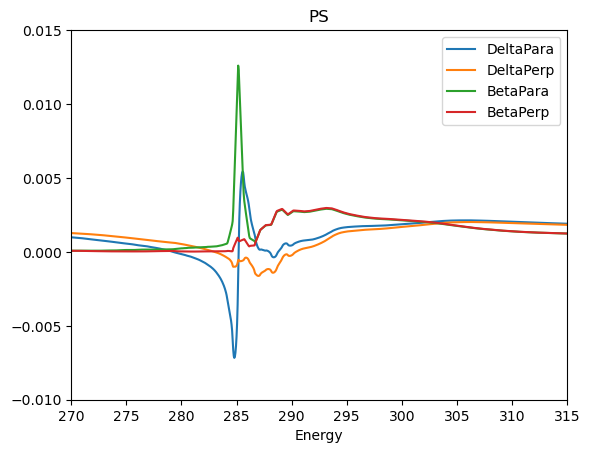

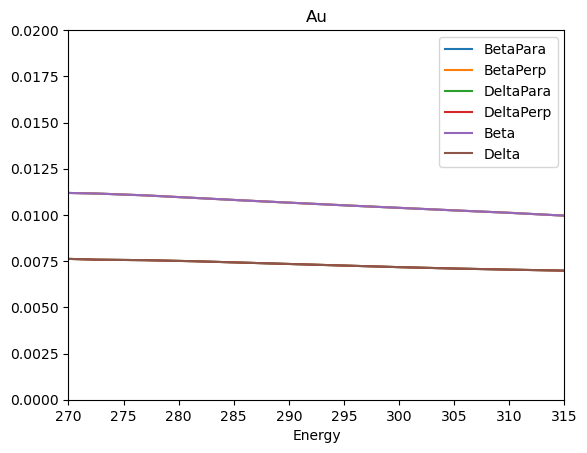

In [27]:
# we strongly recommend visualization of the index of refraction as a function of energy, 
# to ensure that it is loaded as you intended.
ps_uni.plot(x="Energy", xlim = (270,315), ylim = (-.01,0.015), title = "PS")
au_uni.plot(x="Energy", xlim = (270,315), ylim = (0,0.02), title = "Au")

## Construct a default model

In [28]:
morph = coreshell_spheres_decay_euler_16bit(args)

In [29]:
morph

Morphology (NumMaterial : 3, PhysSize : 2.5)

### Visualize the model

Model visualization is a key step in any NRSS model workflow, to ensure that the intent of the model design is realized in the model that will be simulated.
<br>We will use the visualize_materials method of the morphology object

Dataset dimensions (Z, Y, X): 32 x 512 x 512
Number of Materials: 3

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 0.10952107608318329
Material 1 theta. Min: 0.0 Max: 3.140625
Material 1 psi. Min: -2.9765625 Max: 3.140625


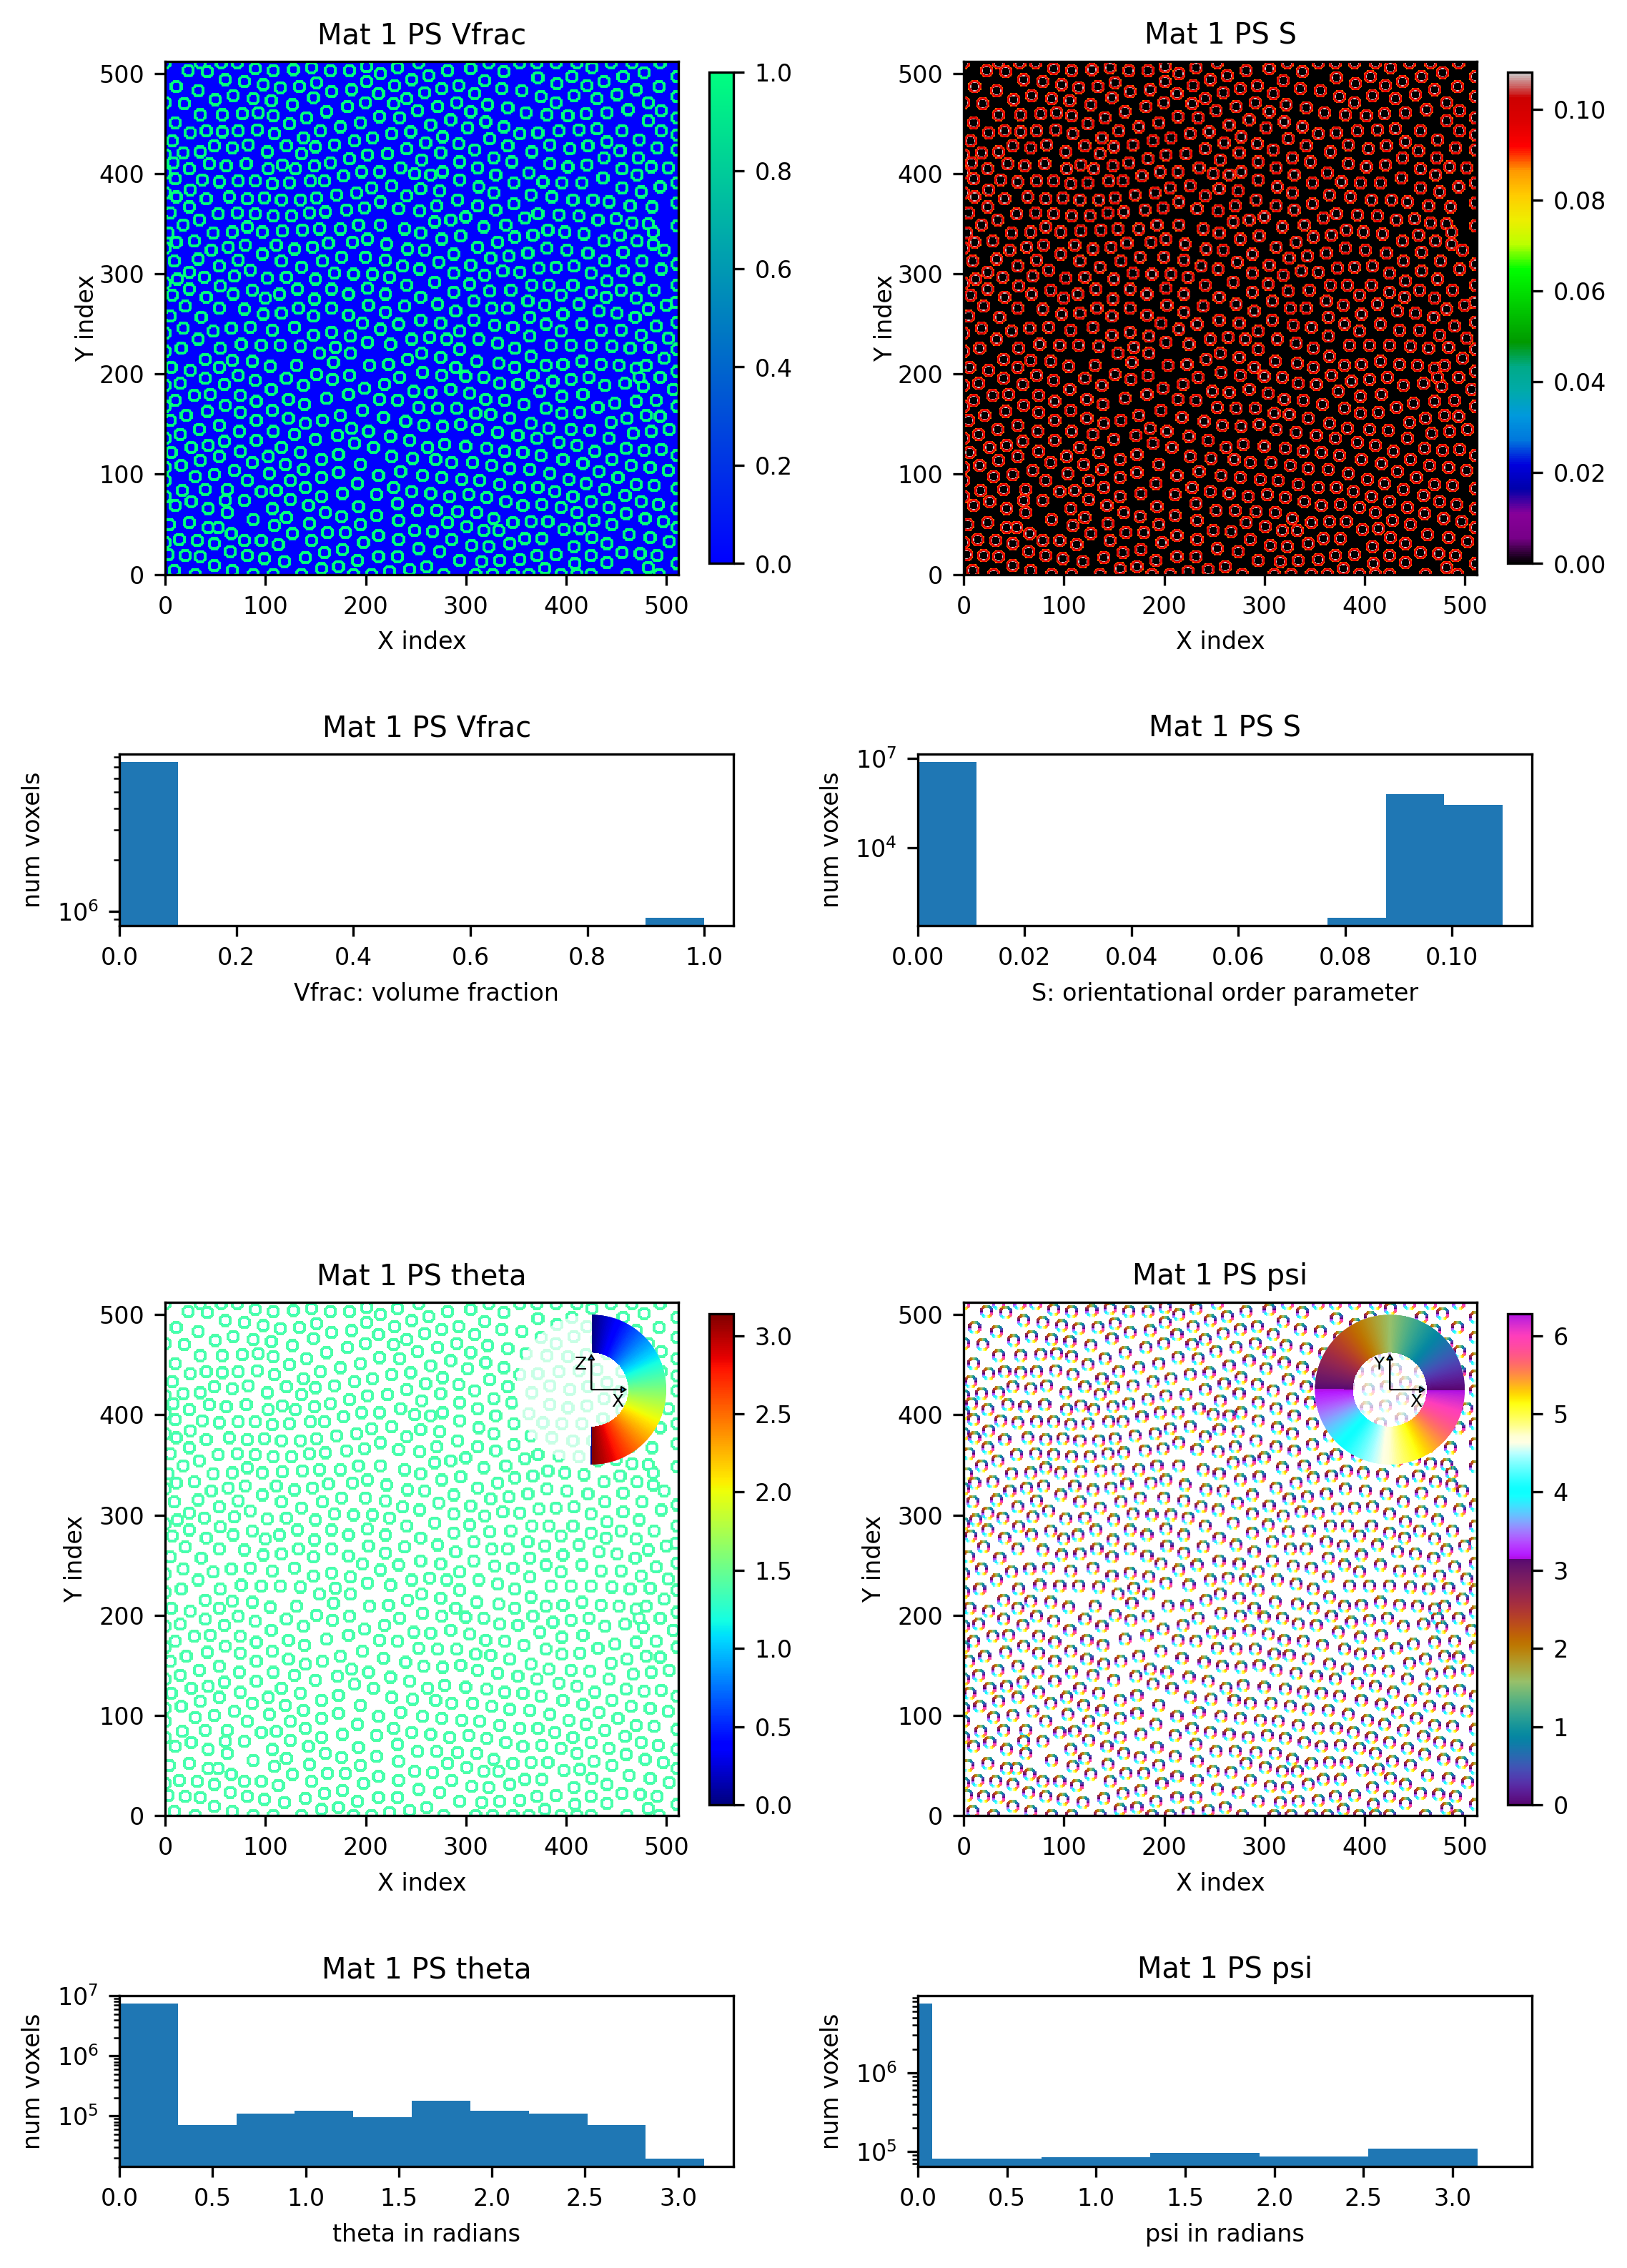

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 0.0 Max: 0.0


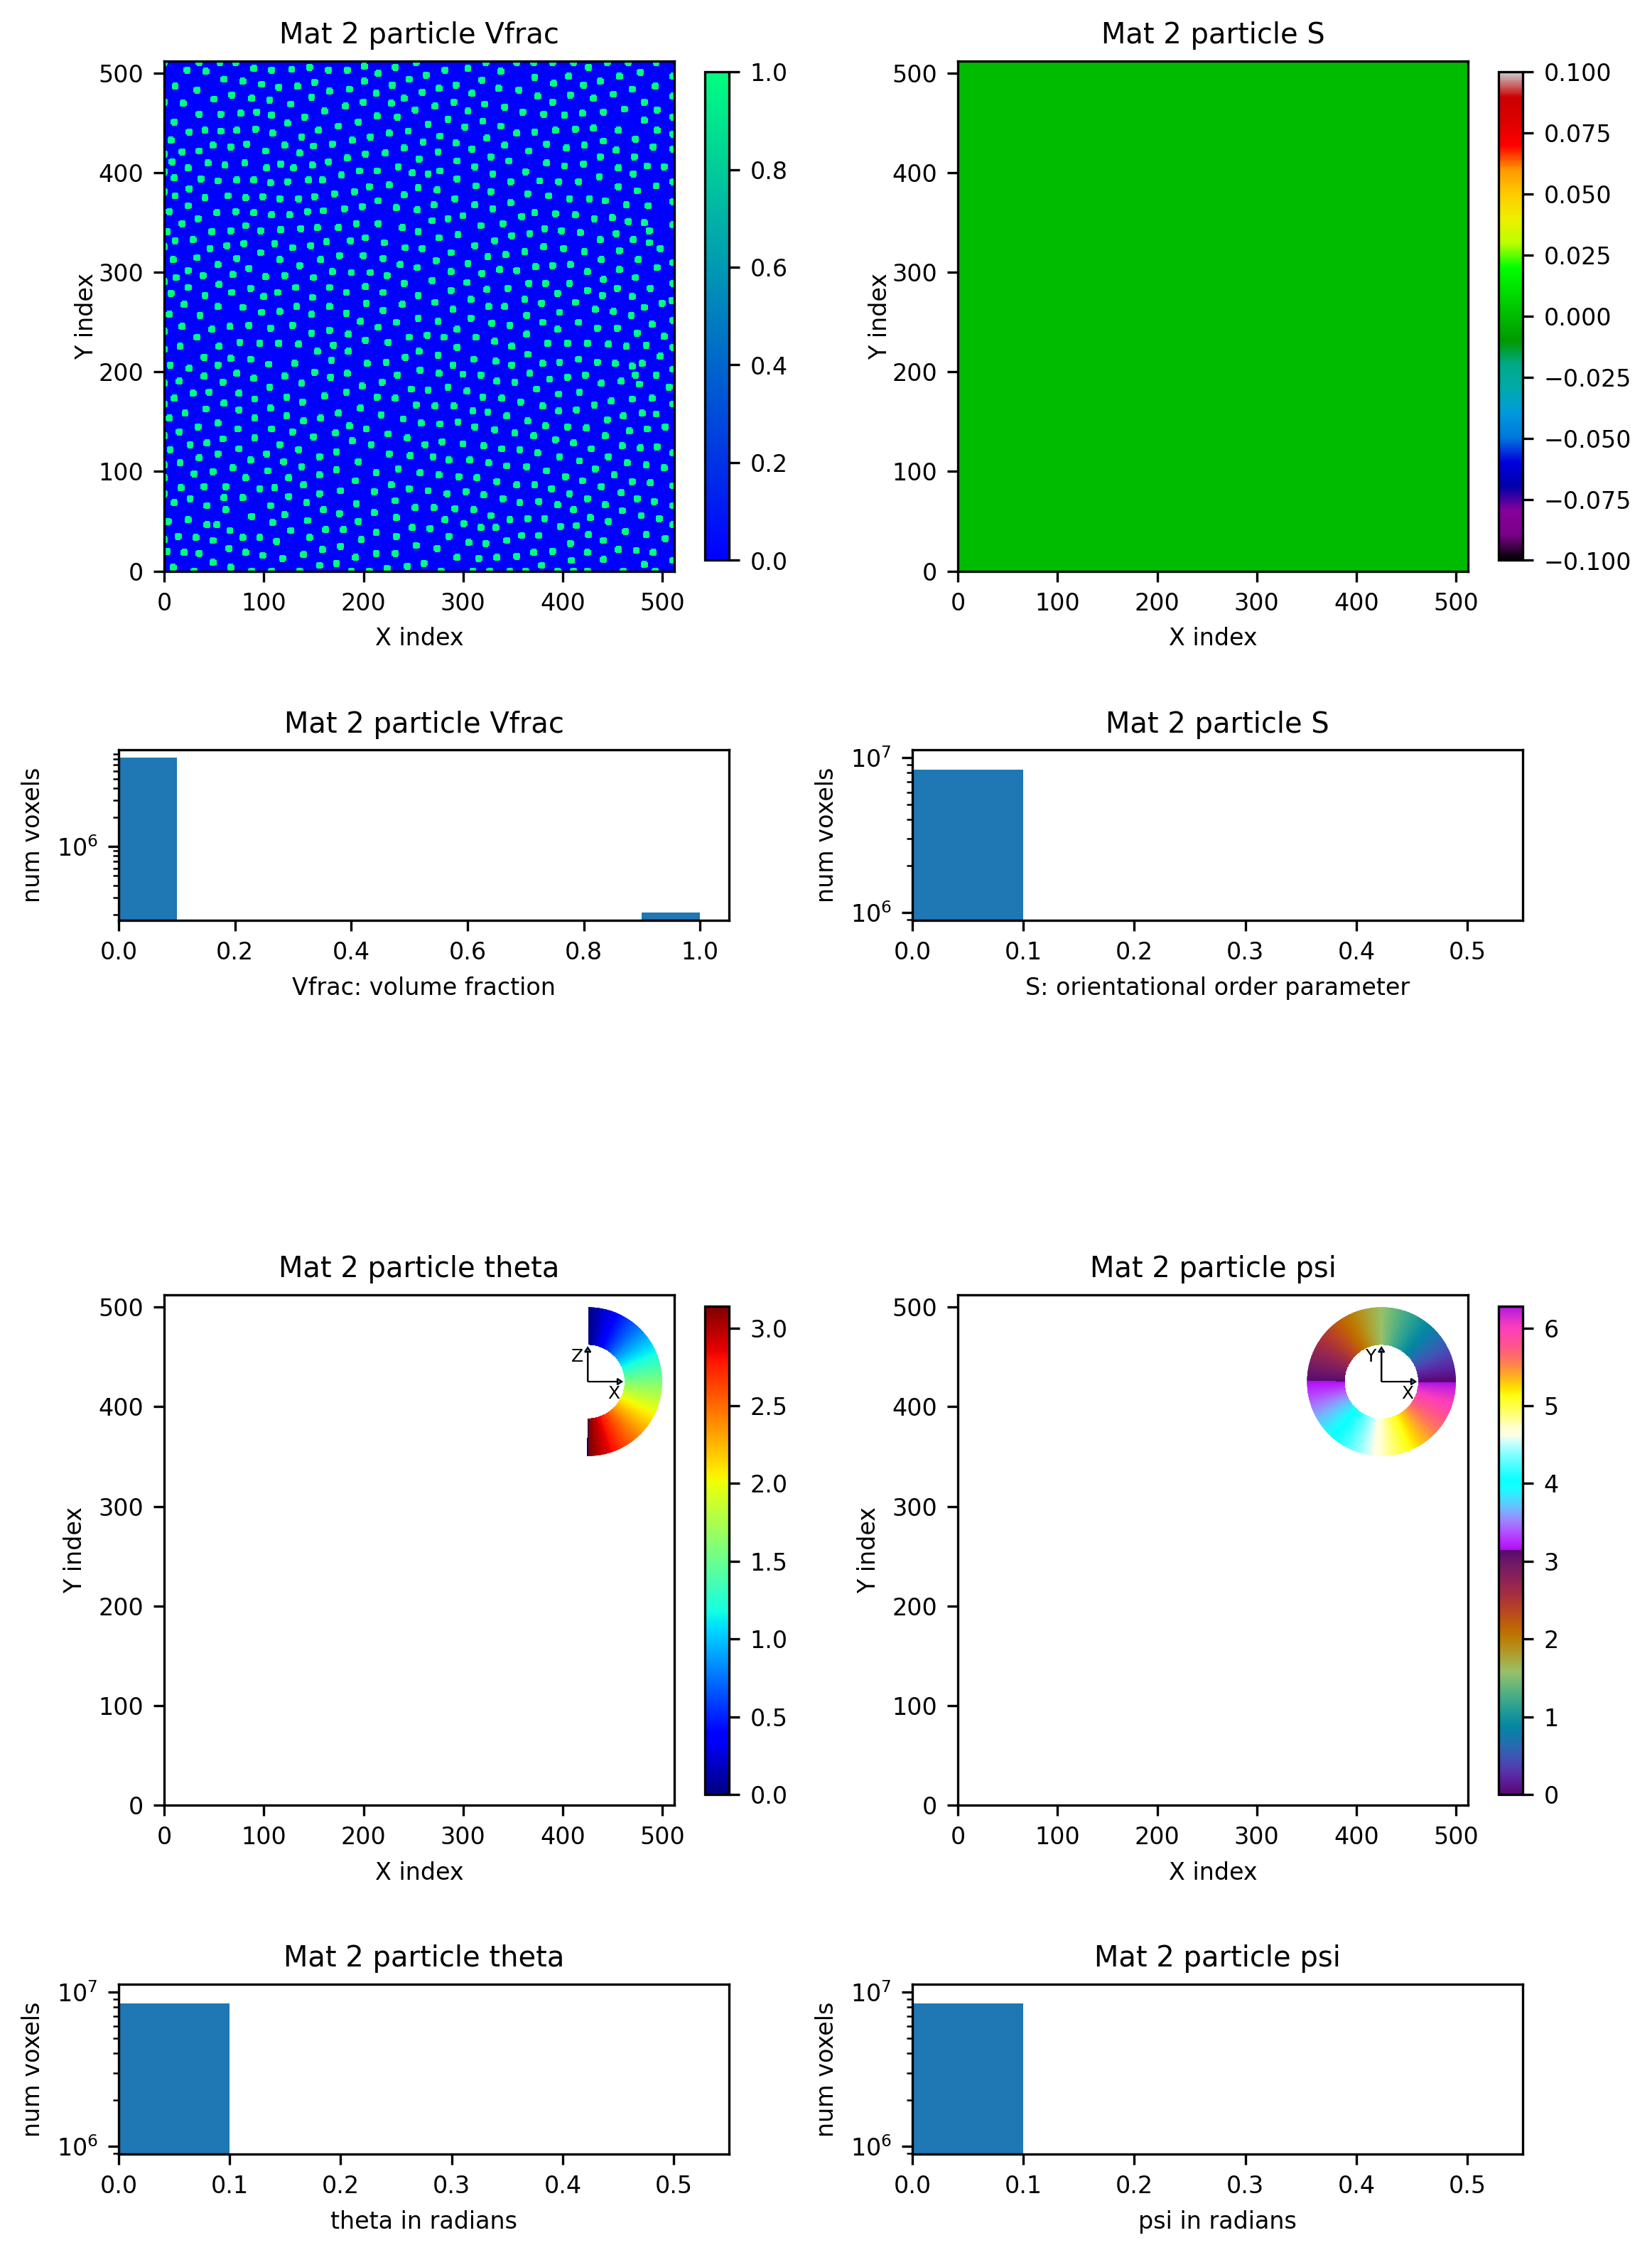

Material 3 Vfrac. Min: 0.0 Max: 1.0
Material 3 S. Min: 0.0 Max: 0.0
Material 3 theta. Min: 0.0 Max: 0.0
Material 3 psi. Min: 0.0 Max: 0.0


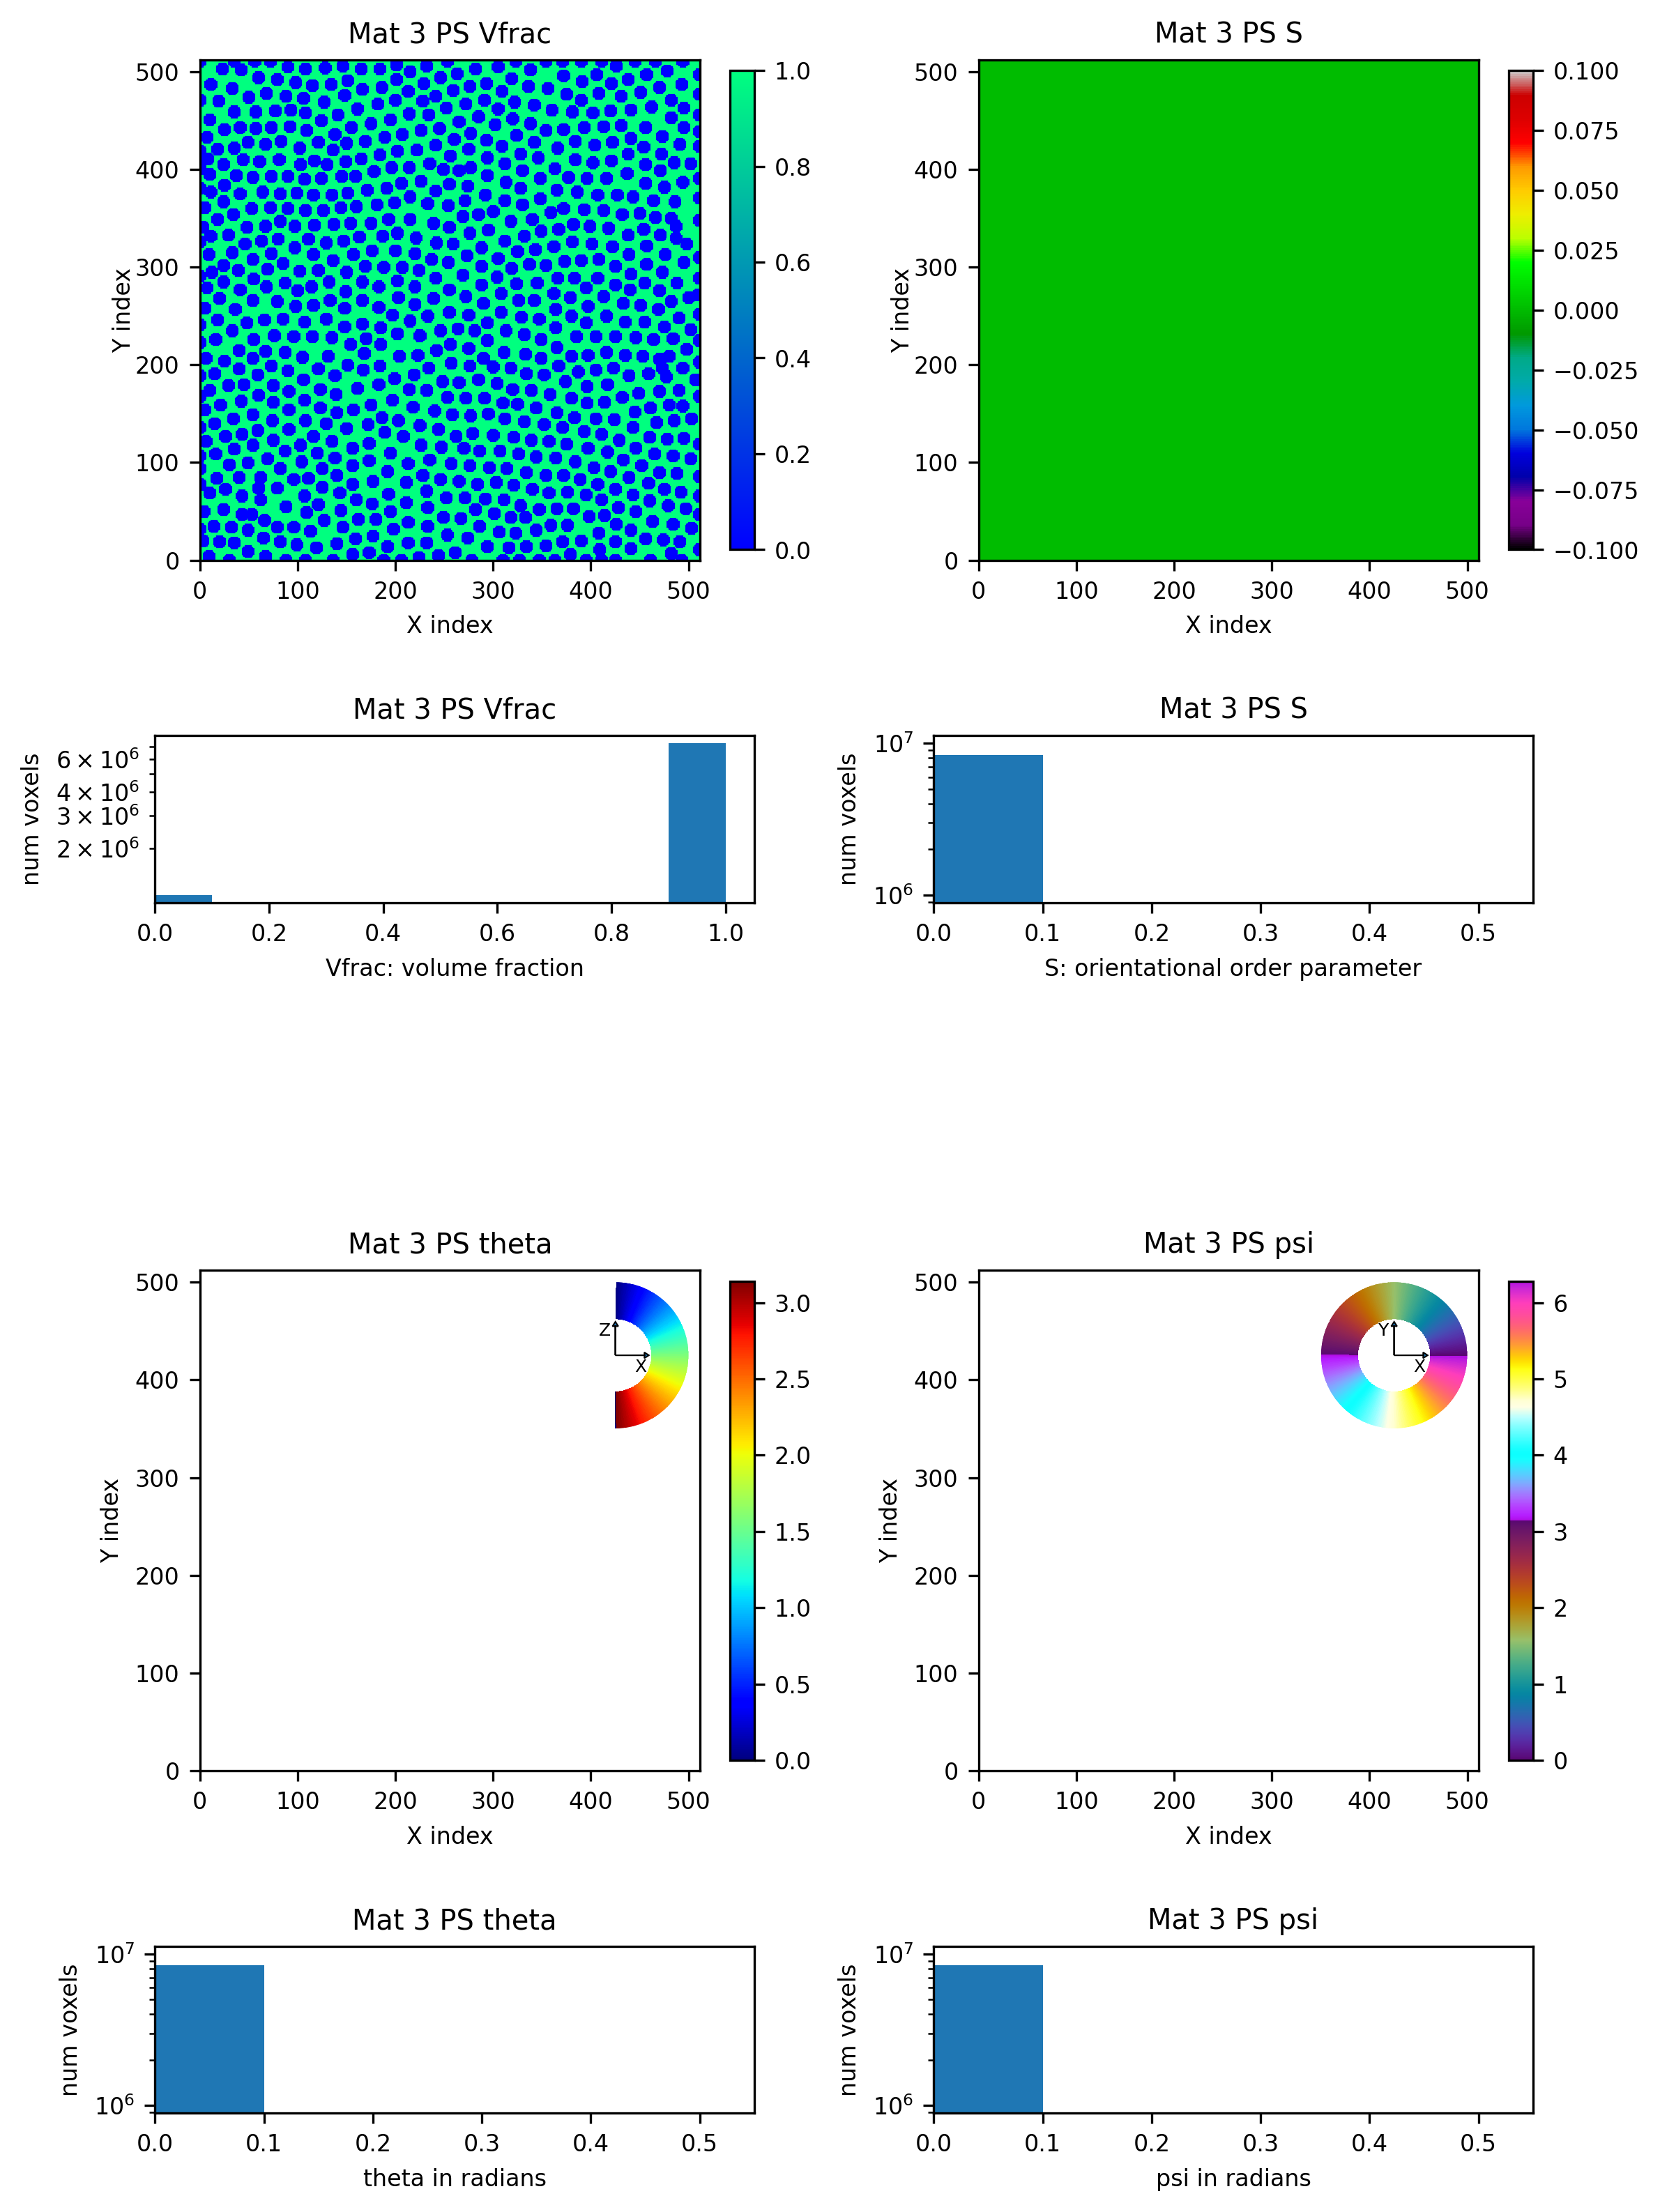

[]

<Figure size 640x480 with 0 Axes>

In [30]:
morph.visualize_materials(z_slice = 16)

In [31]:
# seeking closeup on orientation field

from matplotlib import pyplot as plt


psi_viz = morph.visualize_materials(z_slice = 16, subsample = 32, add_quiver = True, runquiet = True, outputmat = [1], outputplot = ['psi'])


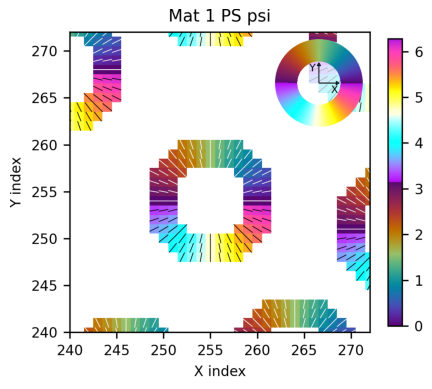

In [32]:
plt.imshow(psi_viz[0])
plt.gca().set_axis_off()

Everything looks very radial!

the NRSS will add vertical slices to future versions, to confirm out-of-plane orientations

## Running model

### Model execution

In [33]:
args.return_2d = True
results = coreshell_spheres_run(args)

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 94.32it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


### Examine 2D patterns

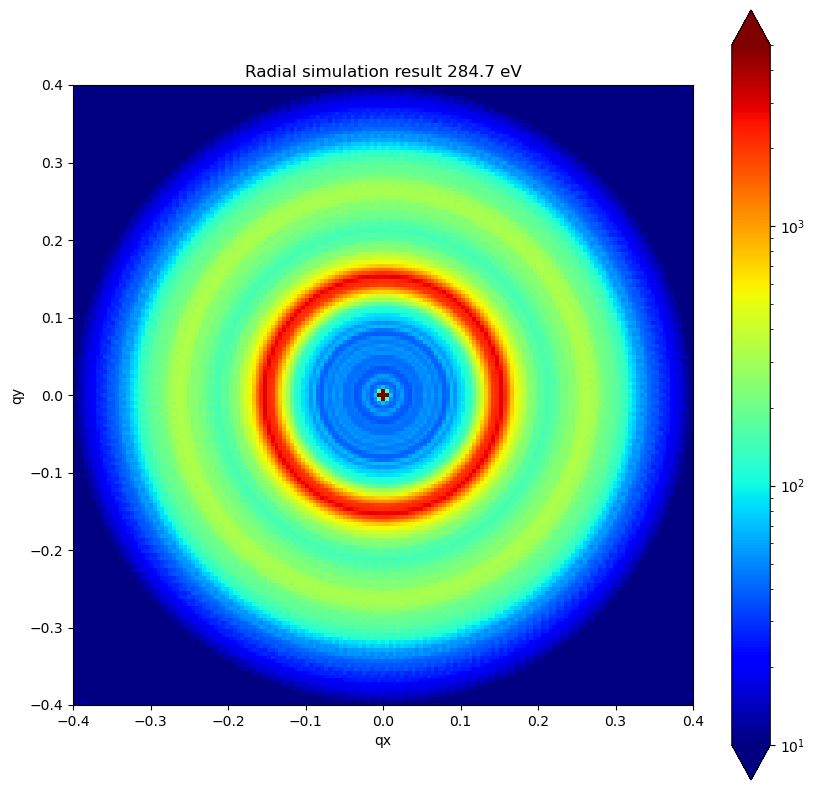

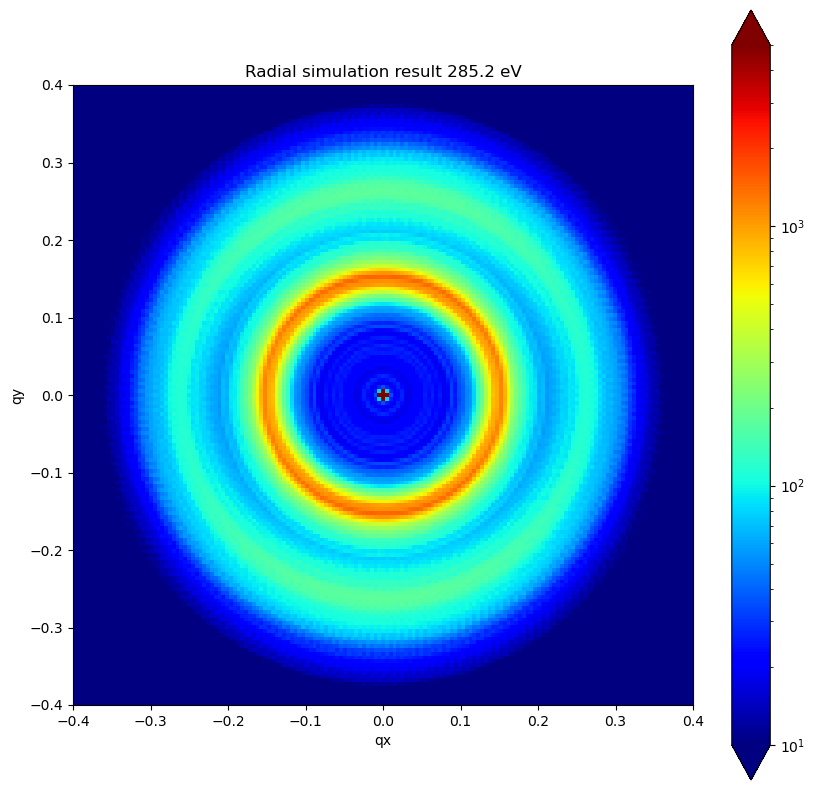

In [34]:
from matplotlib import colors

for energy in [284.7, 285.2]:
    fig, ax = plt.subplots(figsize = (10,10))
    ax.axes.set_aspect('equal')
    results.twod.sel(energy = energy, method = 'nearest').plot(ax = ax, vmin = 10, vmax = 5E3, xlim = (-.4, .4), ylim = (-.4, .4), norm = colors.LogNorm(), cmap = 'jet')
    # results.twod.sel(energy = energy, method = 'nearest').plot(ax = ax, vmin = 10, vmax = 5E3, xlim = (-.4, .4), ylim = (-.4, .4), norm = colors.LogNorm(), cmap = 'jet')
    plt.title(f"Radial simulation result {energy} eV")
    plt.show()
    plt.close

### Examine I vs. q

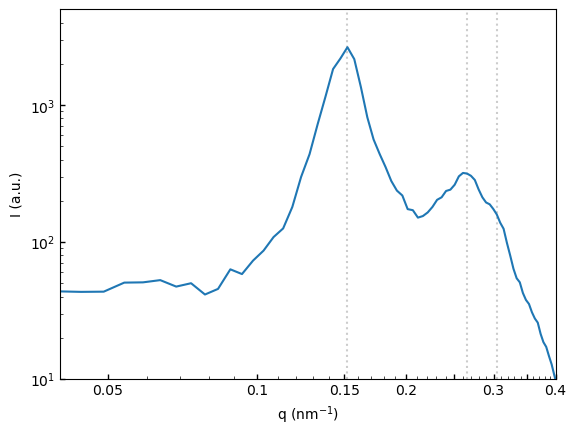

In [35]:
# A bunch of matplotlib commands to make the plot look nice

from matplotlib import ticker
from matplotlib.ticker import NullFormatter

results.I.sel(energy=284.7, method = 'nearest').plot()
major_ticklabels = [0.05, 0.1, 0.15, 0.2, "", 0.3, "", 0.4]
major_ticks = np.arange(0.05, 0.45, 0.05)
minor_ticks = np.arange(0.05, 0.41, 0.01)
y_min = 10
y_max = 5E3

for vert in [0.152, 0.265, 0.305]:
    plt.vlines(vert, y_min, y_max, color='k', linestyle='dotted', alpha = 0.2, zorder = -100)

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(y_min,y_max)
ax.set_xlim(0.04, 0.40)
ax.set_title("")
ax.set_xticks(major_ticks)
ax.set_xticklabels(major_ticklabels)
ax.set_xticks(minor_ticks, minor=True)
ax.tick_params(axis="y", which="major", direction="in", width=1.0)
ax.tick_params(axis="y", which="minor", direction="in", width=0.5)
ax.tick_params(axis="x", which="major", direction="in", width=1.0)
ax.tick_params(axis="x", which="minor", direction="in", width=0.5)
# ax.xaxis.set_major_formatter("{x: .2f}")
ax.xaxis.set_minor_formatter(NullFormatter())

ax.set_xlabel("q (nm$^{-1}$)")
ax.set_ylabel("I (a.u.)")

plt.show()
plt.close()

### Examine A vs. q

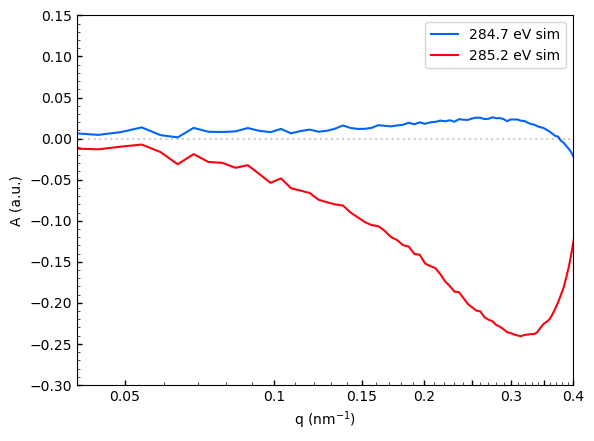

In [36]:


results.A.sel(energy=284.7, method = 'nearest').plot(color = 'xkcd:bright blue',label = '284.7 eV sim')
results.A.sel(energy=285.2, method = 'nearest').plot( color = 'xkcd:bright red',label = '285.2 eV sim')
ax = plt.gca()
ax.hlines(0, 0.04, 0.40, color='k', alpha = 0.2, linestyle='dotted')
ax.set_xscale("log")
ax.set_xlim(0.04, 0.40)
ax.set_ylim(-0.3, 0.15)
ax.set_title("")
ax.set_xticks(major_ticks)
ax.set_xticklabels(major_ticklabels)
ax.set_xticks(minor_ticks, minor=True)
ax.tick_params(axis="y", which="major", direction="in", width=1.0)
ax.tick_params(axis="y", which="minor", direction="in", width=0.5)
ax.tick_params(axis="x", which="major", direction="in", width=1.0)
ax.tick_params(axis="x", which="minor", direction="in", width=0.5)
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.set_xlabel("q (nm$^{-1}$)")
ax.set_ylabel("A (a.u.)")
ax.legend()
plt.show()
plt.close()


## Variable sweep demonstration

This section uses some functions written in pgn_model.py to orchestrate a parameter sweep and plot the results.

We recommend serializing model results to disk for each simulation so that results can be retrieved quickly later, and that is performed here by run_sweep. Other paradigms are, of course, possible.

In [37]:
num_sweep = 18 #number of steps
results = run_sweep(args, "t", np.linspace(2.5, 15, num_sweep))

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 87.33it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 109.36it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 89.53it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 101.99it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 96.48it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 95.42it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 102.76it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 93.29it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 101.14it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 84.74it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 106.08it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 103.19it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 86.56it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 96.43it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 99.68it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 91.25it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 92.83it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 284.7eV -> 285.2eV
 [STAT] Energy = 284.7 starting 
 [STAT] Energy = 285.2 starting 


100%|██████████| 2/2 [00:00<00:00, 104.28it/s]
/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


['/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_000.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_001.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_002.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_003.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_004.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_005.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_006.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_007.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_008.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_009.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_010.pkl',
 '/homes/deand/NRSS/tutorials/polymer_grafted_nanoparticles/pickles/t_011.pkl',
 '/homes/deand/NRSS/tutorials/polymer_gr

100%|██████████| 18/18 [00:01<00:00,  9.59it/s]


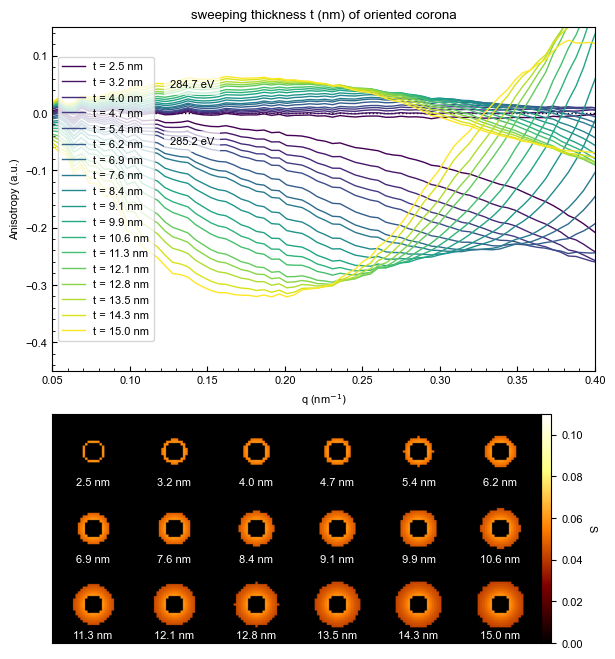

In [38]:
from pgn_model import plot_sweep
plot_sweep("t")